# NSL-KDD

### Importo librerie e dati

In [ ]:
from google.colab import drive
drive.mount('/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Mounted at /drive


In [ ]:
#creo il nome delle colonne
columns = np.array(['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins',
           'logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
           'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
           'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
           'dst_host_srv_rerror_rate','Attack', 'difficulty'])
#features raccoglie le colonne con dati utili all'algoritmo
features = np.array(['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins',
           'logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
           'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
           'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
           'dst_host_srv_rerror_rate'])
#target contiene la colonna con l'output
target = np.array(['Attack'])

In [ ]:
#importo i dataset
train = pd.read_csv('/drive/My Drive/KDDTrain+.txt', names=columns)
test = pd.read_csv('/drive/My Drive/KDDTest+.txt', names=columns)

### Modello il dataset

In [ ]:
#cancello la colonna difficulty in quanto non necessaria
del train['difficulty']
del test['difficulty']

In [ ]:
print('Features Totali:',features.size)
print('Target Totali:',target.size)

Features Totali: 41
Target Totali: 1


In [ ]:
#controllo le dimensioni
print('Train:', train.shape)
print('Test:', test.shape)

Train: (125973, 42)
Test: (22544, 42)


In [ ]:
#Load attacks.txt containing the attack categories
map_attacks = [x.strip().split() for x in open('/drive/My Drive/attackMap.txt', 'r')]
map_attacks = {k:v for (k,v) in map_attacks}

train['Attack'] = train['Attack'].replace(map_attacks)
test['Attack'] = test['Attack'].replace(map_attacks)

In [ ]:
train.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
# unisco train e test per fare l'encoding
df = pd.concat([train, test])

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.shape

(148517, 42)

In [ ]:
attackStatus=[]
for i in df['Attack']:
    if i =="normal":
        attackStatus.append("normal")
    else:
        attackStatus.append("attack")           
df['Attack']=attackStatus

In [ ]:
#Inizio a fare l'encoding degli object in category
for i in columns:
    if df[i].dtypes==object:
        print(i + ": " + str(df[i].dtype))
        df[i] = df[i].astype('category')
        if i=="Attack":
            break
        df=pd.get_dummies(df, columns=[i])   

protocol_type: object
service: object
flag: object
Attack: object


In [ ]:
#feature e labels
xCol = df.columns.drop('Attack')
x = df[xCol].values
dummies = pd.get_dummies(df['Attack']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

### Creo i dati del training

In [ ]:
# normalizzazione
x = preprocessing.scale(x)
x = preprocessing.normalize(x)

In [ ]:
import io
import requests
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X = x[:125973] #sarà il train+validation
xTest = x[125973:] # dati nuovi usati esclusivamente per l'evaluation
Y = y[:125973] 
yTest = y[125973:]

In [ ]:
xTrain, xVal, yTrain, yVal = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(len(xTrain), "Training sequences",xTrain.shape)
print(len(yTrain), "Training sequences",yTrain.shape)
print(len(xVal), "Validation sequences",xVal.shape)
print(len(yVal), "Validation sequences",yVal.shape)

100778 Training sequences (100778, 122)
100778 Training sequences (100778, 2)
25195 Validation sequences (25195, 122)
25195 Validation sequences (25195, 2)


### Creazione del modello Sequenziale

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def AuCscore(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
auc = tf.keras.metrics.AUC()

In [ ]:
model = Sequential()
model.add(Dense(10, input_dim=xTrain.shape[1], activation='relu'))
model.add(Dense(50, input_dim=xTrain.shape[1], activation='relu'))
model.add(Dense(10, input_dim=xTrain.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(yTrain.shape[1],activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto',
                           restore_best_weights=True)

#### Training

In [ ]:
model.fit(xTrain,yTrain,validation_data=(xVal,yVal),
          callbacks=[monitor],epochs=1000)

Epoch 1/1000
3150/3150 [==============================] - 9s 3ms/step - loss: 0.1456 - accuracy: 0.9540 - val_loss: 0.0644 - val_accuracy: 0.9772
Epoch 2/1000
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0551 - accuracy: 0.9796 - val_loss: 0.0495 - val_accuracy: 0.9802
Epoch 3/1000
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0481 - accuracy: 0.9822 - val_loss: 0.0467 - val_accuracy: 0.9823
Epoch 4/1000
3150/3150 [==============================] - 8s 3ms/step - loss: 0.0452 - accuracy: 0.9838 - val_loss: 0.0451 - val_accuracy: 0.9845
Epoch 5/1000
3150/3150 [==============================] - 8s 3ms/step - loss: 0.0434 - accuracy: 0.9844 - val_loss: 0.0404 - val_accuracy: 0.9856
Epoch 6/1000
3150/3150 [==============================] - 8s 3ms/step - loss: 0.0411 - accuracy: 0.9855 - val_loss: 0.0399 - val_accuracy: 0.9861
Epoch 7/1000
3150/3150 [==============================] - 8s 3ms/step - loss: 0.0396 - accuracy: 0.9860 - val_loss: 0.0399 -

#### Evaluation

In [ ]:
prediction = model.predict(xTest)
pred = np.argmax(prediction,axis=1)
y_eval = np.argmax(yTest,axis=1)
score = metrics.accuracy_score(y_eval, pred)
#auc = AuCscore(pred, y_eval)
print("Validation score: {}".format(score))
print("Area under the curve score: {}".format(auc))

Validation score: 0.9872249822569198
Area under the curve score: AUC(name=auc,dtype=float32,num_thresholds=200,curve=ROC,summation_method=interpolation,multi_label=False,label_weights=None)


In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_eval, pred)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

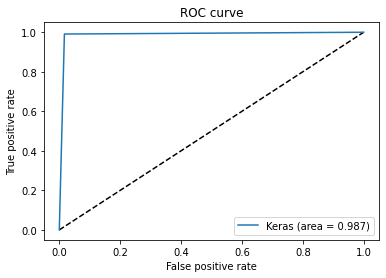

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Conversione

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
open("/drive/My Drive/kddModel2.tflite","wb").write(tflite_model)

11692

### Conversione file C

In [ ]:
!apt-get -qq install xxd
!xxd -i '/drive/My Drive/kddModel2.tflite' > '/drive/My Drive/kddModel2.c'
!cat '/drive/My Drive/kddModel2.c'

Selecting previously unselected package xxd.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
unsigned char _drive_My_Drive_kddModel2_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x90, 0x00, 0x00, 0x00, 0xc0, 0x00, 0x00, 0x00, 0xb0, 0x25, 0x00, 0x00,
  0xc0, 0x25, 0x00, 0x00, 0x48, 0x2d, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 

### Creazione input per file C

In [ ]:
from numpy import savetxt

In [ ]:
inArray = xVal[5]

In [ ]:
inArray.shape

(122,)

In [ ]:
outArray = yVal[5]

In [ ]:
outArray

array([1, 0], dtype=uint8)

In [ ]:
savetxt('/drive/My Drive/inArray2.txt', inArray, delimiter=' ,')
savetxt('/drive/My Drive/outArray2.txt', outArray, delimiter=' ,')

### Validazione

In [ ]:
prediction = model.predict(xTest)
pred = np.argmax(prediction,axis=1)
y_eval = np.argmax(yTest,axis=1)
score = metrics.accuracy_score(y_eval, pred)
auc = AuCscore(pred, y_eval)
print("Validation score: {}".format(score))
print("Area under the curve score: {}".format(auc))

Validation score: 0.9872249822569198
Area under the curve score: 0.9873435878718458
